# Download scores file

To run this notebook, please first download the scores zip file at
https://drive.google.com/open?id=1eTjsmUz3orClxWSshwLmTWaxE003bcrP
and unzipped under the same directory in which this notebook is located.

In [1]:
%matplotlib inline
import os
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


sources = ['All', 'AGSO', 'JAMSTEC', 'JAMSTEC2', 'NGA', 'NGDC', 'NOAA_geodas', 'SIO', 'US_multi']

configs = []
config_trained_with_all = []

data_dir = "new-scores/instance_base-per-region"
filename_temp = "scores_ms_{}_{}_1"
# data_dir_all = "new-scores/instance_base-all"
data_dir_all = "new-scores/instance_base-all"
filename_temp_all = "testing_result_{}"
config_name = "instance-base"
configs.append((data_dir, filename_temp, config_name))
config_trained_with_all.append((data_dir_all, filename_temp_all))

data_dir = "new-scores/cruise_base-per-region"
filename_temp = "testing_result_{}.pkl"
data_dir_all = "new-scores/cruise_base-all/"
# data_dir_all = "new-scores/cruise_base-all"
filename_temp_all = "testing_result_{}.pkl"
config_name = "cruise-base, weighted"
configs.append((data_dir, filename_temp, config_name))
config_trained_with_all.append((data_dir_all, filename_temp_all))


cache = {}
def get_label_normalized_scores(data_dir, filename_temp, model):
    global cache

    filename = os.path.join(data_dir, filename_temp.format(model, model))
    if filename in cache:
        ret = cache[filename]
    else:
        try:
            with open(filename, 'rb') as f:
                (n_pos, n_neg), array = pkl.load(f)
                ret = (n_pos, n_neg), array
        except:
            print(filename)
            ret = None
        cache[filename] = ret
    return ret


def get_performance(true, scores, weights):
    # loss
    # loss = np.mean(true * -np.log(scores) + (1 - true) * -np.log(1.0 - scores))
    loss = 0.0
    # auprc
    precision, recall, _ = precision_recall_curve(true, scores, sample_weight=weights, pos_label=1)
    auprc = auc(recall, precision)
    # auroc
    fpr, tpr, _ = roc_curve(true, scores, sample_weight=weights, pos_label=1)
    auroc = auc(fpr, tpr)
    # accuracy
    acc = np.sum(true == (scores > 0.5)) / true.shape[0]
    return (loss, acc, (precision, recall, auprc), (fpr, tpr, auroc))

In [2]:
cache_all = []
for (i, (data_dir_all, filename_temp_all)) in enumerate(config_trained_with_all):
    total_pos, total_neg = 0, 0
    label_score_weight = np.empty([0, 3])
    for j, source in enumerate(sources):
        if source.lower() == "all":
            continue
        ret = get_label_normalized_scores(data_dir_all, filename_temp_all, source)
        if ret is None:
            continue
        (n_pos, n_neg), array = ret
        total_pos += n_pos
        total_neg += n_neg
        concat = np.concatenate((label_score_weight, array), axis=0)
        del label_score_weight, array
        label_score_weight = concat
    order = np.lexsort((label_score_weight[:, 1], label_score_weight[:, 0]))
    cache_all.append(((total_pos, total_neg), label_score_weight[order]))

new-scores/instance_base-all/testing_result_JAMSTEC2


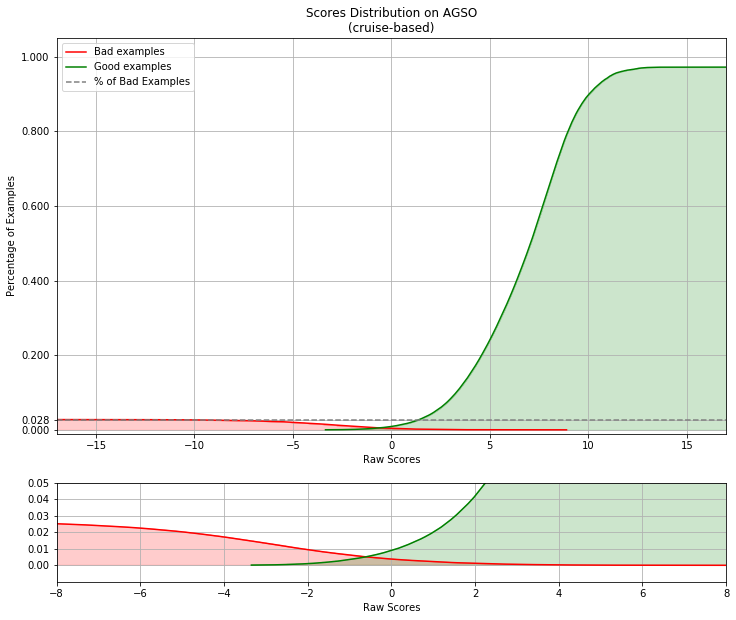

In [192]:
data_dir = "new-scores/cruise_base-per-region"
filename_temp = "testing_result_{}.pkl"
source = "AGSO"
ret = get_label_normalized_scores(data_dir, filename_temp, source)
(n_pos, n_neg), label_score_weight = ret
n_pos, n_neg,

pos_rate = n_pos / (n_pos + n_neg)
neg_rate = 1.0 - pos_rate

from matplotlib import gridspec

fig, ax = plt.subplots(1, 1, figsize=(12, 10))


gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])


step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

pos_index = np.argmax(label_score_weight[:, 0] > 0)
if label_score_weight[pos_index, 0] <= 0:
    pos_index = label_score_weight.shape[0]
# some scores are not mapped to [-1, 1], but mapped to [0, 1], so fix them here
if np.min(label_score_weight[:, 1]) >= -1e-3:
    label_score_weight[:, 1] = 2 * label_score_weight[:, 1] - 1
margin_neg = label_score_weight[:pos_index, 1]
margin_pos = label_score_weight[pos_index:, 1]

y = 1.0 - np.cumsum(label_score_weight[pos_index:, 2]) / np.sum(label_score_weight[pos_index:, 2])  # np.arange(1, margin_pos.shape[0] + 1)[::-1] / (margin_pos.shape[0] + 1)
step = max(1, int(len(y) / 5000))
x = margin_pos[::step]
x = 0.5 * (x + 1)
x = np.log(x / (1.0 - x))
x = -x
y = (1.0 - y[::step]) * pos_rate
ax.plot(x, y, c='r', label="Bad examples")
ax.fill_between(x, y, alpha=0.2, color='r', **step_kwargs)

y = np.cumsum(label_score_weight[:pos_index, 2]) / np.sum(label_score_weight[:pos_index, 2])  # np.arange(1, margin_neg.shape[0] + 1) / (margin_neg.shape[0] + 1)
step = max(1, int(len(y) / 5000))
x = margin_neg[::step]
x = 0.5 * (x + 1)
x = np.log(x / (1.0 - x))
x = -x
x = [19.0] + list(x)
y = [1.0] + list(1.0 - y[::step])
y = np.array(y) * neg_rate
ax.plot(x, y, label="Good examples", c="green")
ax.fill_between(x, y, alpha=0.2, color='green', **step_kwargs)

ax.grid();
ax.axhline(n_pos / (n_pos + n_neg), ls='--', color="gray", label="% of Bad Examples");
ax.set_title("Scores Distribution on {}\n({})".format(source, "cruise-based"));
ax.set_ylim(-0.01, 1.05)
# ax.set_xlim(-1.05, 1.05);
ax.set_xlim(-17.0, 17.0)
ax.set_xlabel("Raw Scores")
ax.set_ylabel("Percentage of Examples");
# ax.text(-17, 0.03, "0.028", fontsize=12, c="gray")
# ax.set_xticks([t for t in range(-14, 20, 2)])
ax.legend();

ax.set_yticks([0, n_pos / (n_pos + n_neg), 0.2, 0.4, 0.6, 0.8, 1.0])


#####
ax = ax1

y = 1.0 - np.cumsum(label_score_weight[pos_index:, 2]) / np.sum(label_score_weight[pos_index:, 2])  # np.arange(1, margin_pos.shape[0] + 1)[::-1] / (margin_pos.shape[0] + 1)
step = max(1, int(len(y) / 5000))
x = margin_pos[::step]
x = 0.5 * (x + 1)
x = np.log(x / (1.0 - x))
x = -x
y = (1.0 - y[::step]) * pos_rate
ax.plot(x, y, c='r', label="Bad examples")
ax.fill_between(x, y, alpha=0.2, color='r', **step_kwargs)

y = np.cumsum(label_score_weight[:pos_index, 2]) / np.sum(label_score_weight[:pos_index, 2])  # np.arange(1, margin_neg.shape[0] + 1) / (margin_neg.shape[0] + 1)
step = max(1, int(len(y) / 5000))
x = margin_neg[::step]
x = 0.5 * (x + 1)
x = np.log(x / (1.0 - x))
x = -x
x = [19.0] + list(x)
y = [1.0] + list(1.0 - y[::step])
y = np.array(y) * neg_rate
ax.plot(x, y, label="Good examples", c="green")
ax.fill_between(x, y, alpha=0.2, color='green', **step_kwargs)

ax.grid();
# ax.axhline(n_pos / (n_pos + n_neg), ls='--', color="gray", label="% of Bad Examples");
# ax.set_title("Scores Distribution on {}\n({})".format(source, "cruise-based"));
ax.set_ylim(-0.01, 0.05)
# ax.set_xlim(-1.05, 1.05);
ax.set_xlim(-8, 8.0)
ax.set_xlabel("Raw Scores")
ax.set_yticks([0.0, 0.01, 0.02, 0.03, 0.04, 0.05])
# ax.set_ylabel("Percentage of Examples");
# ax.text(-8, 0.05, "2.8%", fontsize=12, c="gray")
# ax.legend();


####

fig.savefig("agso-scores.pdf", format="pdf")


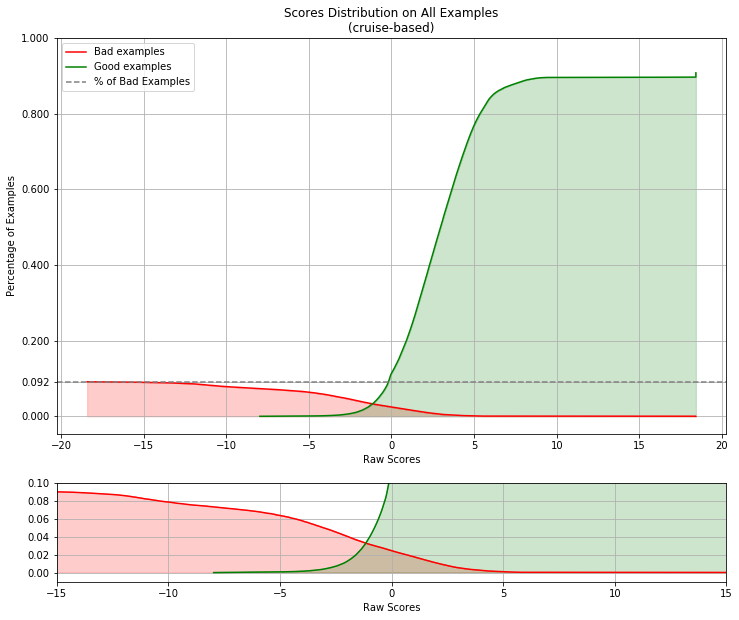

In [194]:
(n_pos, n_neg), label_score_weight = cache_all[1]


from matplotlib import gridspec

fig, ax = plt.subplots(1, 1, figsize=(12, 10))


gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])


step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

pos_index = np.argmax(label_score_weight[:, 0] > 0)
if label_score_weight[pos_index, 0] <= 0:
    pos_index = label_score_weight.shape[0]
# some scores are not mapped to [-1, 1], but mapped to [0, 1], so fix them here
if np.min(label_score_weight[:, 1]) >= -1e-3:
    label_score_weight[:, 1] = 2 * label_score_weight[:, 1] - 1
margin_neg = label_score_weight[:pos_index, 1]
margin_pos = label_score_weight[pos_index:, 1]

label_score_weight[:, 2] = label_score_weight[:, 2] / np.sum(label_score_weight[:, 2])
y = np.cumsum(label_score_weight[pos_index:, 2])  # np.arange(1, margin_pos.shape[0] + 1)[::-1] / (margin_pos.shape[0] + 1)
rate_bad = np.max(y)
step = max(1, int(len(y) / 5000))
x = margin_pos[::step]
x = 0.5 * (x + 1)
x = np.clip(x, 1e-8, 1-1e-8)
x = np.log(x / (1.0 - x))
x = -x
y = y[::step]

ax.plot(x, y, c='r', label="Bad examples")
ax.fill_between(x, y, alpha=0.2, color='r', **step_kwargs)

ax1.plot(x, y, c='r', label="Bad examples")
ax1.fill_between(x, y, alpha=0.2, color='r', **step_kwargs)

y = np.cumsum(label_score_weight[:pos_index, 2]) # np.arange(1, margin_neg.shape[0] + 1) / (margin_neg.shape[0] + 1)
y = np.max(y) - y
step = max(1, int(len(y) / 5000))
x = margin_neg[::step]
x = 0.5 * (x + 1)
x = np.clip(x, 1e-8, 1-1e-8)
x = np.log(x / (1.0 - x))
x = -x
y = y[::step]

ax.plot(x, y, label="Good examples", c="green")
ax.fill_between(x, y, alpha=0.2, color='green', **step_kwargs)

ax1.plot(x, y, label="Good examples", c="green")
ax1.fill_between(x, y, alpha=0.2, color='green', **step_kwargs)

ax.grid();
# ax.axhline(n_pos / (n_pos + n_neg), ls='--', color="gray", label="% of Bad Examples");
ax.set_title("Scores Distribution on All Examples\n(cruise-based)");
# ax.set_ylim(-0.01, 1.05)
# ax.set_xlim(-1.05, 1.05);
# ax.set_xlim(-17.0, 17.0)
ax.set_xlabel("Raw Scores")
ax.set_ylabel("Percentage of Examples");
# ax.text(-17, 0.03, "0.028", fontsize=12, c="gray")
# ax.set_xticks([t for t in range(-14, 20, 2)])
ax.axhline(rate_bad, ls='--', color="gray", label="% of Bad Examples");
ax.legend();

ax1.grid();
ax1.set_xlabel("Raw Scores")
ax1.set_xlim(-15, 15.0)
ax1.set_ylim(-0.01, 0.1)


ax.set_yticks([0, rate_bad, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticks([t / 100.0 for t in range(0, 11, 2)])

fig.savefig("all-scores.pdf", format="pdf")

'''
#####




# ax.axhline(n_pos / (n_pos + n_neg), ls='--', color="gray", label="% of Bad Examples");
# ax.set_title("Scores Distribution on {}\n({})".format(source, "cruise-based"));
# ax.set_xlim(-1.05, 1.05);
ax.set_yticks([0.0, 0.01, 0.02, 0.03, 0.04, 0.05])
# ax.set_ylabel("Percentage of Examples");
# ax.text(-8, 0.05, "2.8%", fontsize=12, c="gray")
# ax.legend();


####

''';

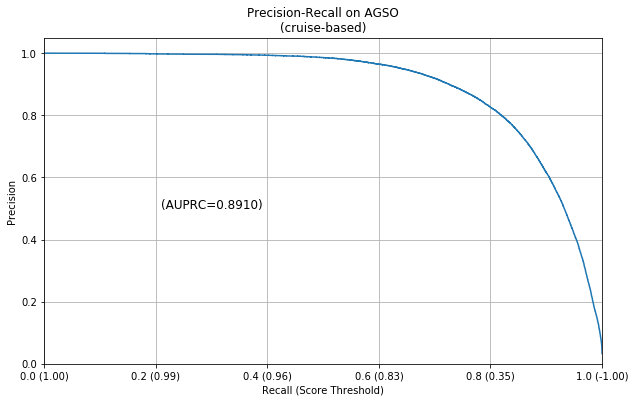

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(_, acc, (precision, recall, auprc), _) = get_performance(
    label_score_weight[:, 0], label_score_weight[:, 1], label_score_weight[:, 2]
)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
ax.step(recall, precision, where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

ax.grid();
ax.set_title("Precision-Recall on {}\n({})".format(source, "cruise-based"));
ax.text(0.21, 0.5, "(AUPRC={:.4f})".format(auprc), fontsize=12)
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_xlabel("Recall (Score Threshold)")
ax.set_ylabel("Precision");

n = np.sum(label_score_weight[:, 0] == 1)
t = [int(n * k / 10.0) for k in range(0, 11, 2)]
scores = label_score_weight[label_score_weight[:, 0] == 1, 1][::-1]
x_ticks = ["%.1f (%.2f)" % (i / 5.0, scores[min(idx, 74428)]) for i, idx in enumerate(t)]
ax.set_xticklabels(x_ticks);

fig.savefig("agso-auprc.pdf", format="pdf");

In [88]:
ls -lrth

total 6656
-rw-r--r--  1 igpp-jalafate  wheel    20K Sep 22 18:33 debug.ipynb
drwxr-xr-x  8 igpp-jalafate  wheel   272B Sep 23 13:45 yf-talk-scores/
drwxr-xr-x  6 igpp-jalafate  wheel   204B Sep 23 13:49 instance-base/
drwxr-xr-x  6 igpp-jalafate  wheel   204B Sep 23 13:55 new-scores/
-rw-r--r--  1 igpp-jalafate  wheel     0B Sep 23 13:59 new-scores.zip
-rw-r--r--  1 igpp-jalafate  wheel   1.8M Sep 23 14:03 JA010034.tsv_all
drwxr-xr-x  3 igpp-jalafate  wheel   102B Sep 23 14:13 format/
-rw-r--r--  1 igpp-jalafate  wheel   102K Sep 24 10:36 show-cruise-path.ipynb
-rw-r--r--  1 igpp-jalafate  wheel    18K Sep 26 13:37 agso.pdf
-rw-r--r--  1 igpp-jalafate  wheel   1.2M Sep 26 14:03 yf-talk-downsample.ipynb
-rw-r--r--  1 igpp-jalafate  wheel    42K Sep 26 14:04 agso-auprc.pdf


new-scores/instance_base-per-region/scores_ms_JAMSTEC2_JAMSTEC2_1


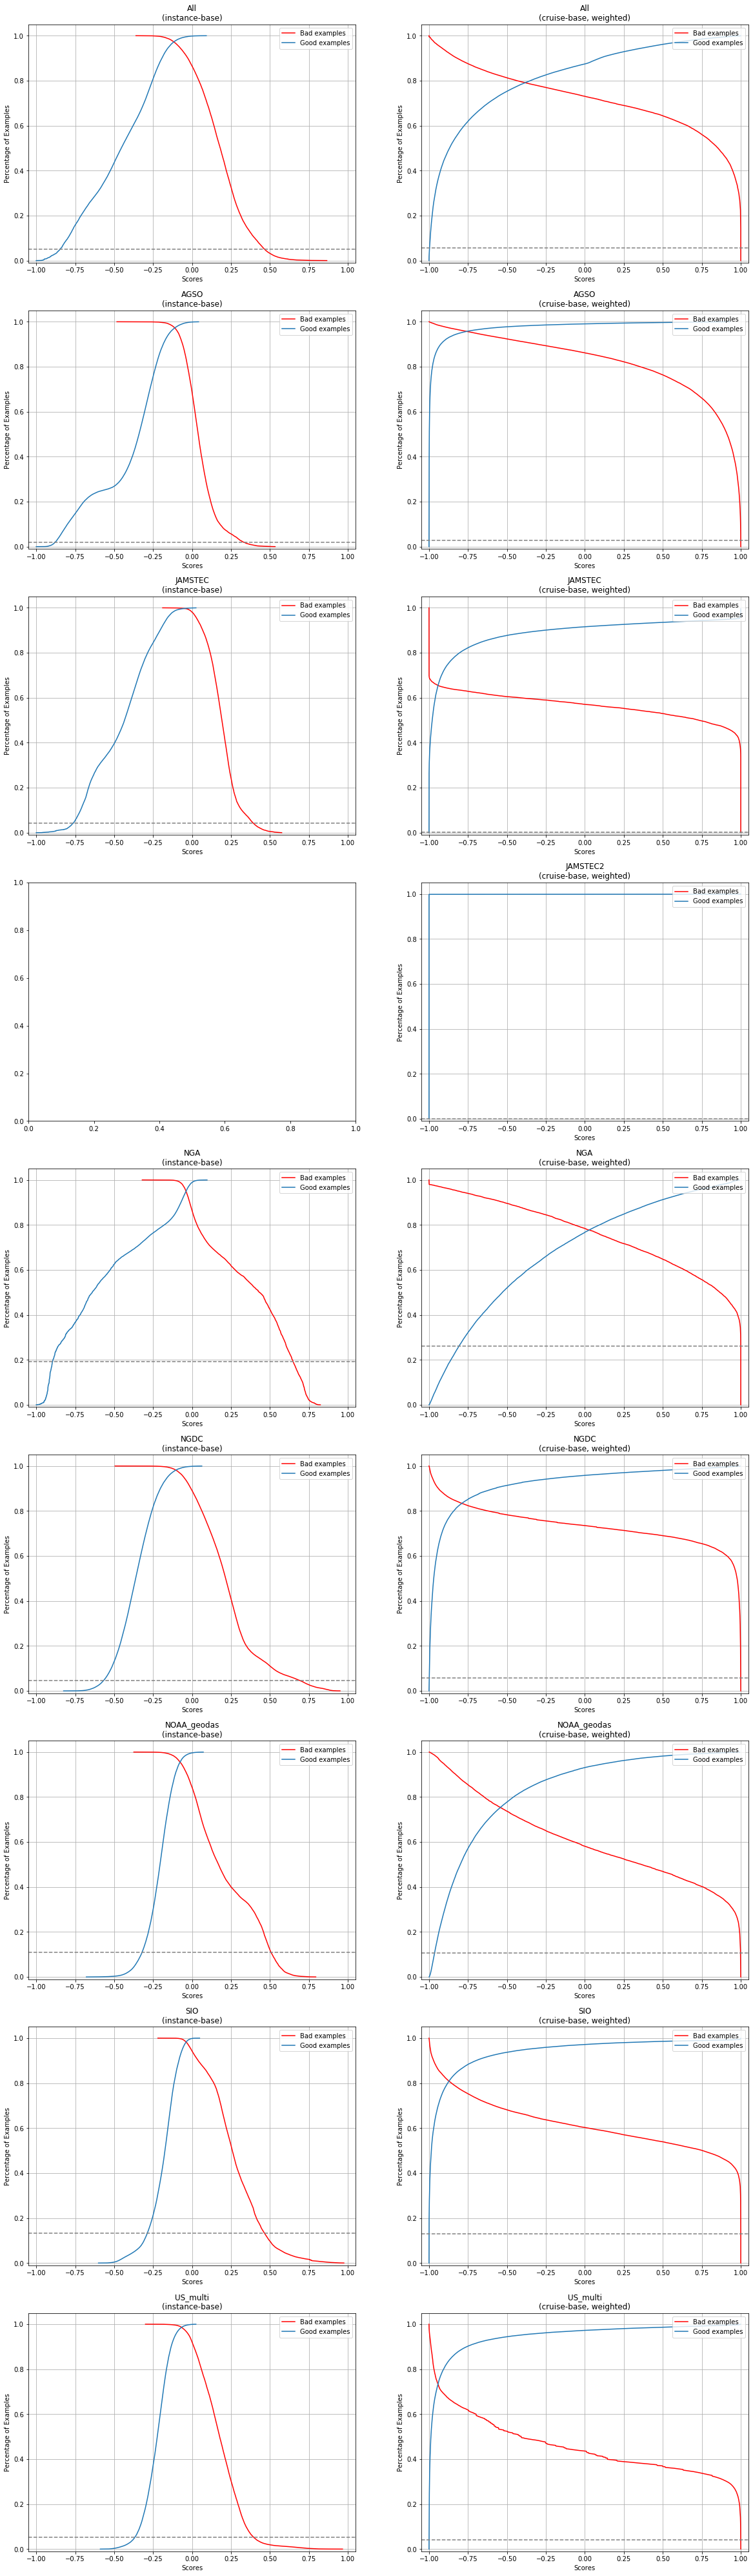

In [5]:
fig, ax_list = plt.subplots(len(sources), 2, figsize=(10 * 2, 8 * (len(sources))))

for i, (data_dir, filename_temp, config_name) in enumerate(configs):
    for j, source in enumerate(sources):
        ax = ax_list[j][i]

        if source.lower() == "all":
            (n_pos, n_neg), label_score_weight = cache_all[i]
        else:
            ret = get_label_normalized_scores(data_dir, filename_temp, source)
            if ret is None:
                continue
            (n_pos, n_neg), label_score_weight = ret

        pos_index = np.argmax(label_score_weight[:, 0] > 0)
        if label_score_weight[pos_index, 0] <= 0:
            pos_index = label_score_weight.shape[0]
        # some scores are not mapped to [-1, 1], but mapped to [0, 1], so fix them here
        if np.min(label_score_weight[:, 1]) >= -1e-3:
            label_score_weight[:, 1] = 2 * label_score_weight[:, 1] - 1
        margin_neg = label_score_weight[:pos_index, 1]
        margin_pos = label_score_weight[pos_index:, 1]

        y = 1.0 - np.cumsum(label_score_weight[pos_index:, 2]) / np.sum(label_score_weight[pos_index:, 2])  # np.arange(1, margin_pos.shape[0] + 1)[::-1] / (margin_pos.shape[0] + 1)
        step = max(1, int(len(y) / 5000))
        ax.plot(margin_pos[::step], y[::step], c='r', label="Bad examples")

        y = np.cumsum(label_score_weight[:pos_index, 2]) / np.sum(label_score_weight[:pos_index, 2])  # np.arange(1, margin_neg.shape[0] + 1) / (margin_neg.shape[0] + 1)
        step = max(1, int(len(y) / 5000))
        ax.plot(margin_neg[::step], y[::step], label="Good examples")

        ax.grid();
        ax.legend(loc=1);
        ax.axhline(n_pos / (n_pos + n_neg), ls='--', color="gray");
        ax.set_title("{}\n({})".format(source, config_name));
        ax.set_ylim(-0.01, 1.05)
        ax.set_xlim(-1.05, 1.05);
        ax.set_xlabel("Scores")
        ax.set_ylabel("Percentage of Examples")

# Save AUROC and AUPRC in tables

In [6]:
auroc_table = {"instance-base": {}, "cruise-base": {}}
auprc_table = {"instance-base": {}, "cruise-base": {}}

for i, (data_dir, filename_temp, config_name) in enumerate(configs):
    for j, source in enumerate(sources):
        ax = ax_list[j][i]

        if source.lower() == "all":
            (n_pos, n_neg), label_score_weight = cache_all[i]
        else:
            ret = get_label_normalized_scores(data_dir, filename_temp, source)
            if ret is None:
                continue
            (n_pos, n_neg), label_score_weight = ret

        (_, acc, (_, _, auprc), (_, _, auroc)) = get_performance(
            label_score_weight[:, 0], label_score_weight[:, 1], label_score_weight[:, 2]
        )

        auroc_table[config_name.split(',')[0]][source] = auroc
        auprc_table[config_name.split(',')[0]][source] = auprc

/Users/igpp-jalafate/dev/virtualenv/py3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/igpp-jalafate/dev/virtualenv/py3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [7]:
for source in auroc_table["instance-base"]:
    print(source, end='\t')
print()
for config_name in auroc_table:
    print(config_name, end='\t')
    for source in auroc_table[config_name]:
        print(auroc_table[config_name][source], end='\t')
    print()

All	AGSO	JAMSTEC	NGA	NGDC	NOAA_geodas	SIO	US_multi	
instance-base	0.9972375243671283	0.9962982349762624	0.9999467337980419	0.9930275592965527	0.9985407526218322	0.9917276484914448	0.998887686913141	0.998920418933023	
cruise-base	0.8818025762871353	0.9920704114903022	0.669973681142874	nan	0.8547649624125789	0.9106483777866861	0.8403029010312392	0.8940984120149762	0.8349491702797311	


In [8]:
for source in auprc_table["instance-base"]:
    print(source, end='\t')
print()
for config_name in auprc_table:
    print(config_name, end='\t')
    for source in auprc_table[config_name]:
        print(auprc_table[config_name][source], end='\t')
    print()

All	AGSO	JAMSTEC	NGA	NGDC	NOAA_geodas	SIO	US_multi	
instance-base	0.9703999312752916	0.9038445664059551	0.9989584397692872	0.9757999691389637	0.9819882908409291	0.964943627889142	0.9944198400145043	0.9899054585725361	
cruise-base	0.6933588455150819	0.8910447282950912	0.14411870409132208	nan	0.8472271704155508	0.7752471361297902	0.600180477377083	0.7211776110536802	0.4525111112009208	


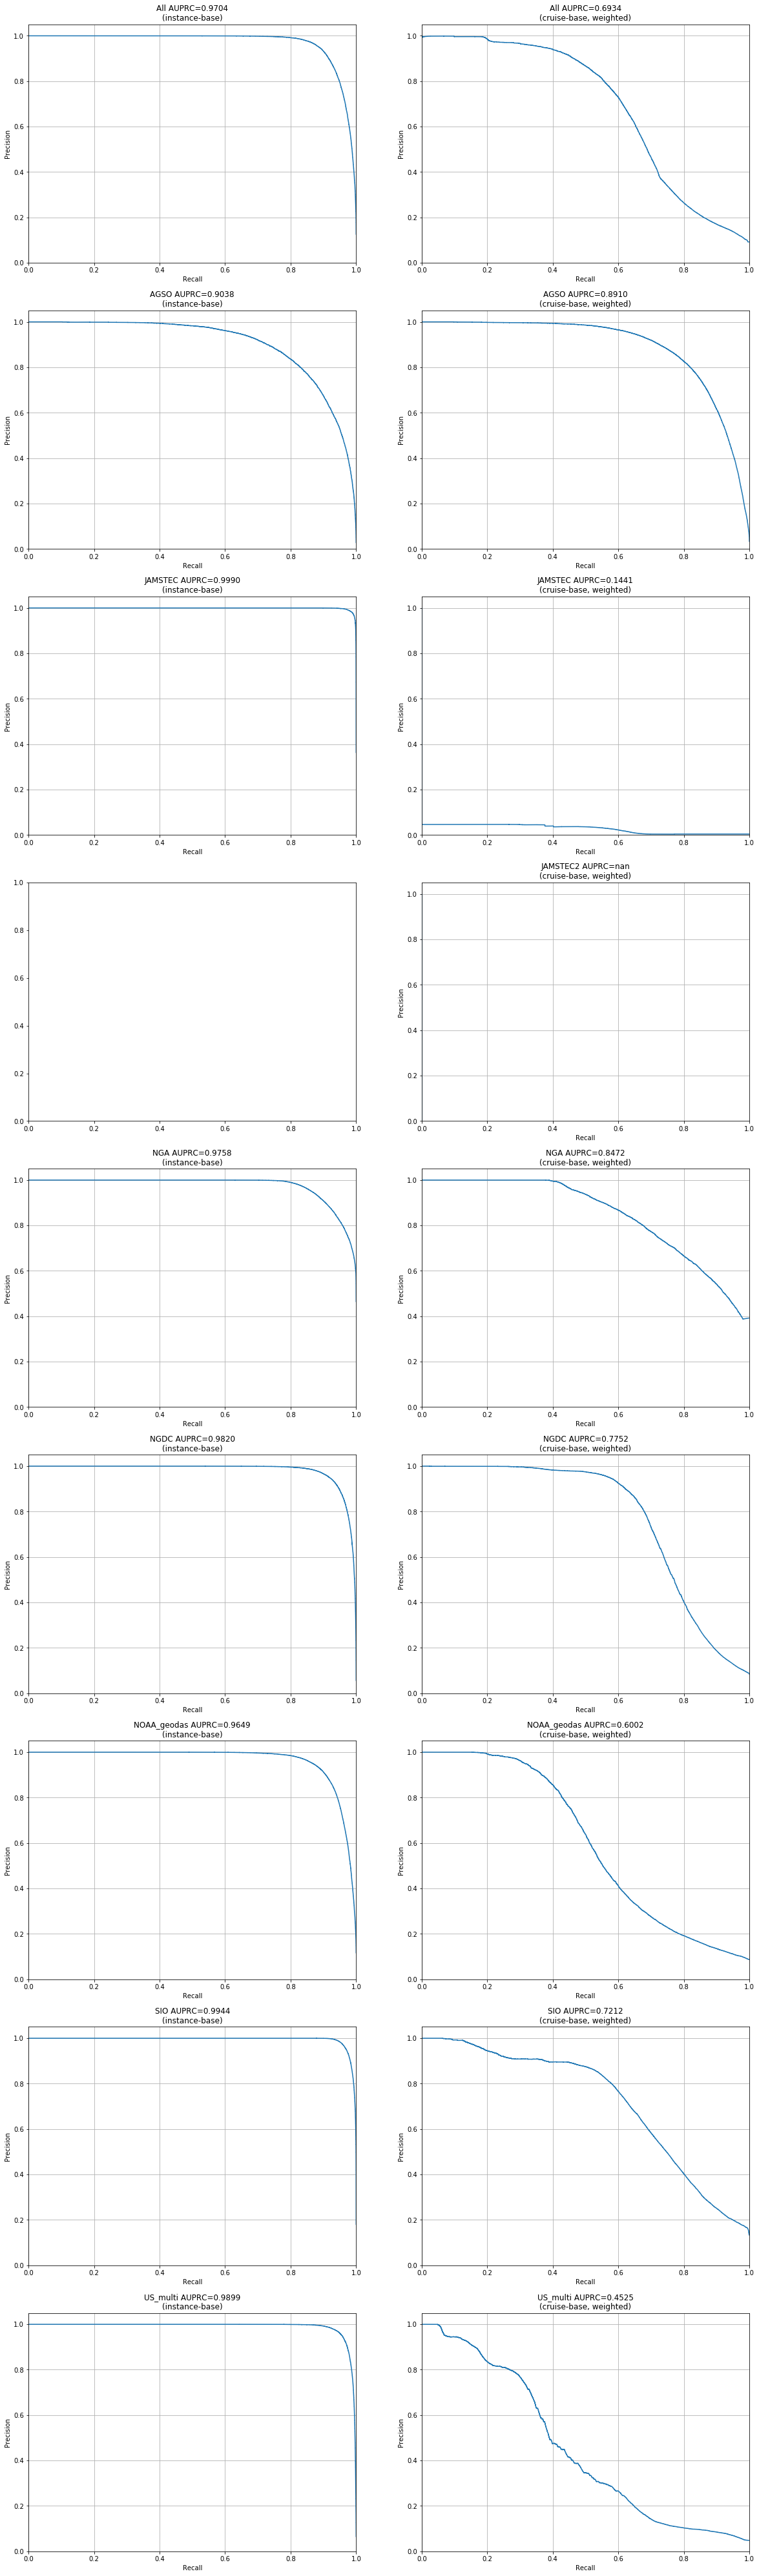

In [9]:
from inspect import signature

fig, ax_list = plt.subplots(len(sources), 2, figsize=(10 * 2, 8 * (len(sources))))

for i, (data_dir, filename_temp, config_name) in enumerate(configs):
    for j, source in enumerate(sources):
        ax = ax_list[j][i]

        if source.lower() == "all":
            (n_pos, n_neg), label_score_weight = cache_all[i]
        else:
            ret = get_label_normalized_scores(data_dir, filename_temp, source)
            if ret is None:
                continue
            (n_pos, n_neg), label_score_weight = ret

        (_, acc, (precision, recall, auprc), _) = get_performance(
            label_score_weight[:, 0], label_score_weight[:, 1], label_score_weight[:, 2]
        )

        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        ax.step(recall, precision, where='post')
        # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

        ax.grid();
        ax.set_title("{} AUPRC={:.4f}\n({})".format(source, auprc, config_name));
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")

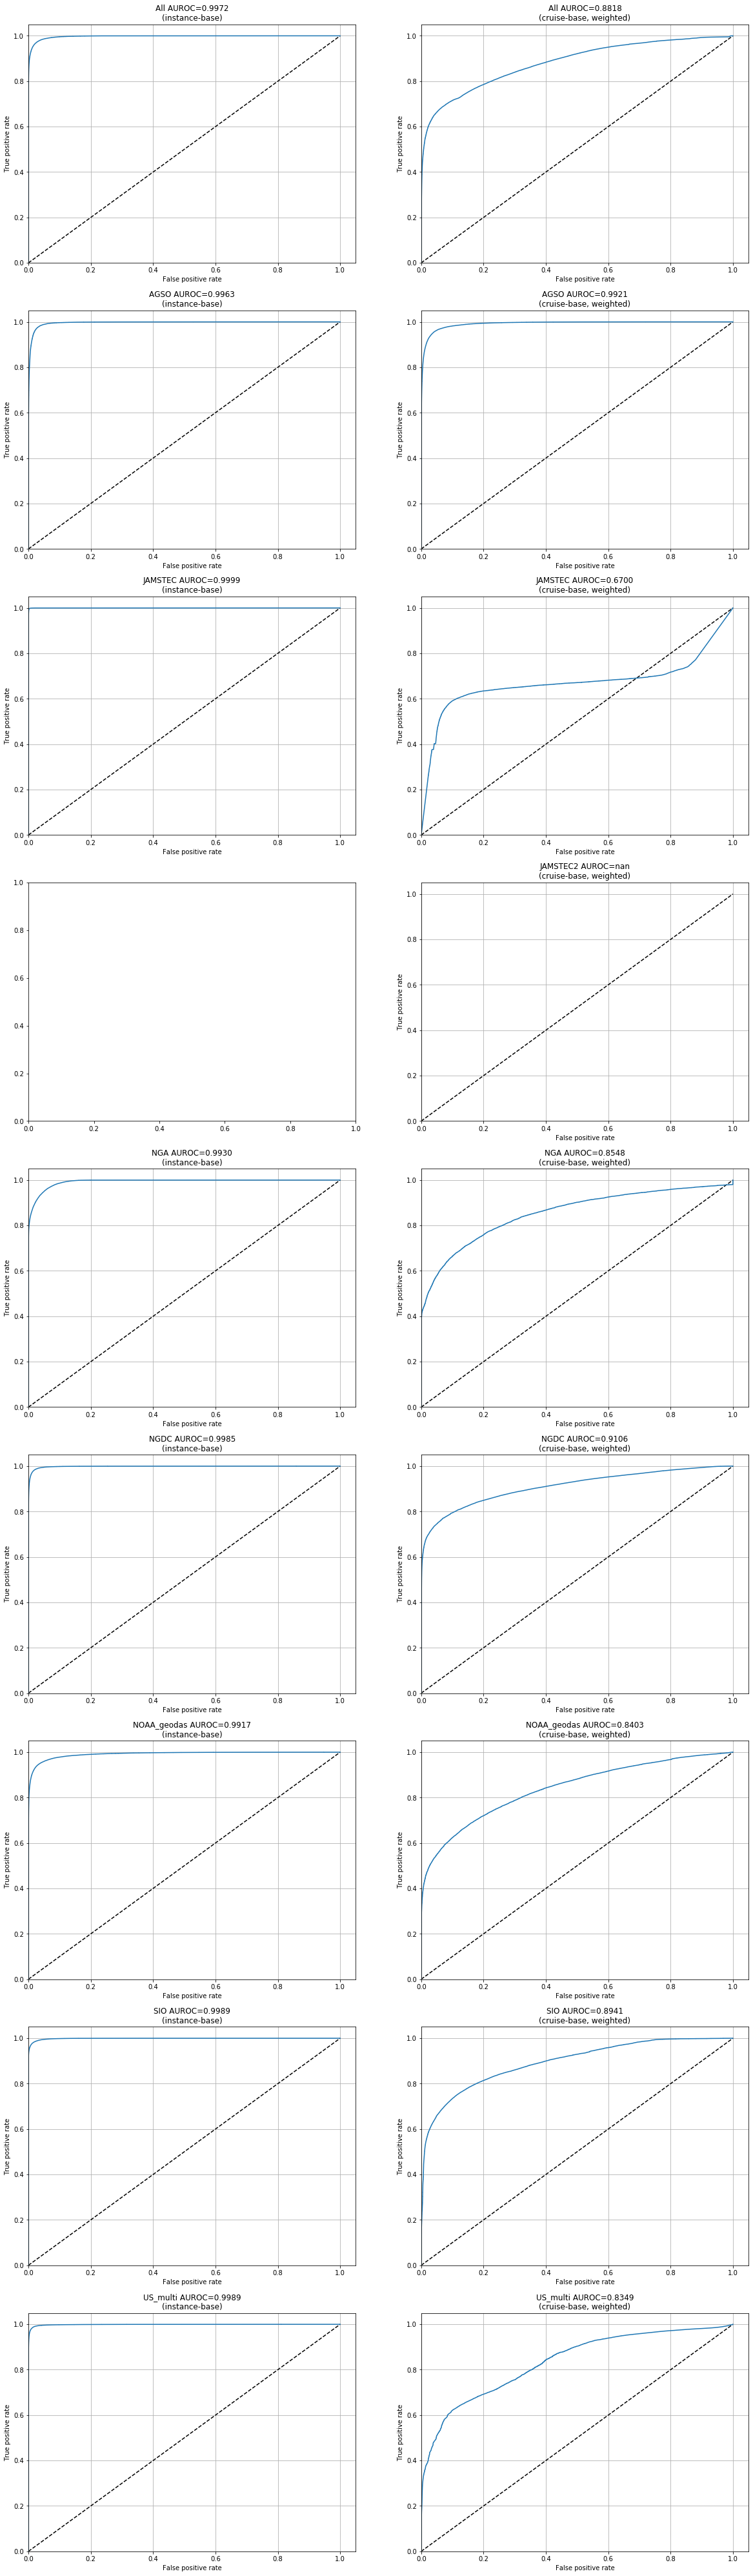

In [10]:
from inspect import signature

fig, ax_list = plt.subplots(len(sources), 2, figsize=(10 * 2, 8 * (len(sources))))

for i, (data_dir, filename_temp, config_name) in enumerate(configs):
    for j, source in enumerate(sources):
        ax = ax_list[j][i]

        if source.lower() == "all":
            (n_pos, n_neg), label_score_weight = cache_all[i]
        else:
            ret = get_label_normalized_scores(data_dir, filename_temp, source)
            if ret is None:
                continue
            (n_pos, n_neg), label_score_weight = ret

        (_, acc, _, (fpr, tpr, auroc)) = get_performance(
            label_score_weight[:, 0], label_score_weight[:, 1], label_score_weight[:, 2]
        )

        ax.plot([0, 1], [0, 1], 'k--')
        ax.plot(fpr, tpr)

        ax.grid();
        ax.set_title("{} AUROC={:.4f}\n({})".format(source, auroc, config_name));
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.05])
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')